<a href="https://colab.research.google.com/github/molinacle/desafio_latam/blob/main/Desaf%C3%ADo_Latam_Desaf%C3%ADo_2_Modelos_Avanzados_y_Redes_Neuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DESAFÍO LATAM - DESAFÍO 2 MODELOS AVANZADOS**
---

*   ALUMNO: SEBASTIÁN MOLINA
*   MODULO: MODELOS AVANZADOS Y REDES NEURONALES
*   CARRERA: DATA SCIENCE

### Descripción del problema de negocio

- **Contexto:** En el campo de la salud, los modelos de Machine Learning pueden ayudar a la detección temprana de posibles enfermedades pudiendo salvar vidas.
En este desafío te enfrentarás a una base de datos real de pacientes con y sin cardiopatía, con el objetivo de poner en práctica los conceptos aprendidos durante las clases de ensambles secuenciales, para la detección de esta enfermedad.


- **Problema de Negocio:** En este proyecto deberás construir tres modelos de Machine Learning de ensambles secuenciales para determinar si una persona padece o no una cardiopatía, a partir de los datos.

### 1. Carga y preparación de los datos

#### a. Cargar los datos y asignar la variable objetivo

In [4]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc

In [5]:
# Lista de nombres de columnas según los atributos descritos
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

# Especificar que "?" es un valor faltante
na_values = ['?']

# Cargar los datos sin encabezados, asignar nombres de columnas y especificar valores faltantes
df_cleveland = pd.read_csv('processed_cleveland.csv', header=None, names=column_names, na_values=na_values)
df_hungarian = pd.read_csv('processed_hungarian.csv', header=None, names=column_names, na_values=na_values)
df_switzerland = pd.read_csv('processed_switzerland.csv', header=None, names=column_names, na_values=na_values)

In [6]:
# Unir los DataFrames en uno solo
df = pd.concat([df_cleveland, df_hungarian, df_switzerland], ignore_index=True)

# Mostrar las primeras filas para verificar
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [7]:
# Asignar a 'num' un 0 cuando su valor es 0, y 1 en otro caso
df['num'] = df['num'].apply(lambda x: 0 if x == 0 else 1)

#### b. Manejo de valores ausentes

In [8]:
# Cantidad de valores ausentes por atributo
missing_values = df.isnull().sum()
print(missing_values)

age           0
sex           0
cp            0
trestbps      3
chol         23
fbs          83
restecg       2
thalach       2
exang         2
oldpeak       6
slope       207
ca          413
thal        320
num           0
dtype: int64


In [9]:
# Porcentaje de valores ausentes
missing_percent = (df.isnull().sum() / len(df)) * 100
print(missing_percent)

age          0.000000
sex          0.000000
cp           0.000000
trestbps     0.416667
chol         3.194444
fbs         11.527778
restecg      0.277778
thalach      0.277778
exang        0.277778
oldpeak      0.833333
slope       28.750000
ca          57.361111
thal        44.444444
num          0.000000
dtype: float64


Vemos que más del 20% de las variables del dataset contienen más del 25% de sus filas con valores nulos, por lo que deben ser eliminadas. También se observa que el 50% de las variables deberán ser imputadas con la media para rellenar los valores nulos. Por lo que solo el 30% aprox. de las variables del dataset se encuentran sin valores nulos. En un caso real me parecería recomendable que al menos el 50% de las variables se encuentre sin nulos para evitar posibles sesgos y overfitting del modelo.

In [10]:
# Columnas con más del 25% de valores ausentes
columns_to_drop = missing_percent[missing_percent > 25].index
print("Columnas a descartar:", columns_to_drop.tolist())

# Eliminar las columnas identificadas
df.drop(columns=columns_to_drop, inplace=True)

Columnas a descartar: ['slope', 'ca', 'thal']


Se imputa con la media pero considerando la clase de cada registro.

In [11]:
# Columnas con valores ausentes menores al 25%
columns_with_missing = missing_percent[(missing_percent > 0) & (missing_percent <= 25)].index
print("Columnas a procesar:", columns_with_missing.tolist())

# Lista de variables categóricas
categorical_vars = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

# Rellenar valores ausentes
for column in columns_with_missing:
    if column in categorical_vars:
        # Rellenar con el promedio según 'num', redondeado al entero más cercano
        df[column] = df.groupby('num')[column].transform(lambda x: x.fillna(round(x.mean())))
    else:
        # Rellenar con el promedio según 'num'
        df[column] = df.groupby('num')[column].transform(lambda x: x.fillna(x.mean()))

Columnas a procesar: ['trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak']


#### c. Creación de variables dummies

In [12]:
# Variables discretas con tres o más categorías
discrete_vars = ['cp', 'restecg']

# Crear variables dummies
df = pd.get_dummies(df, columns=discrete_vars, drop_first=True)

#### d. Análisis descriptivo y visualización

Selección de variables continuas y categóricas

In [13]:
# Variables continuas
continuous_vars = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Variables categóricas
binary_vars = ['sex', 'fbs', 'exang', 'num']

Histogramas para las variables continuas:

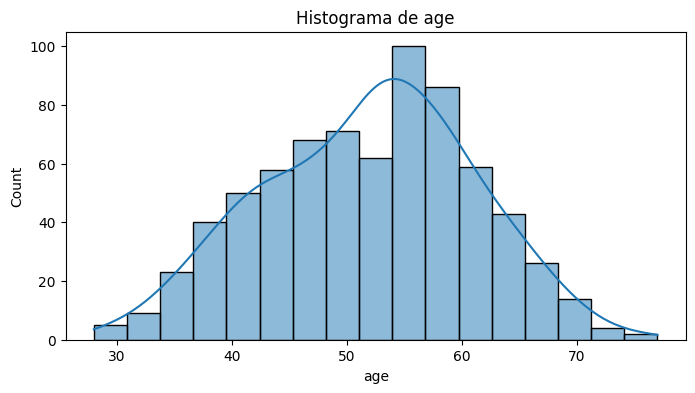

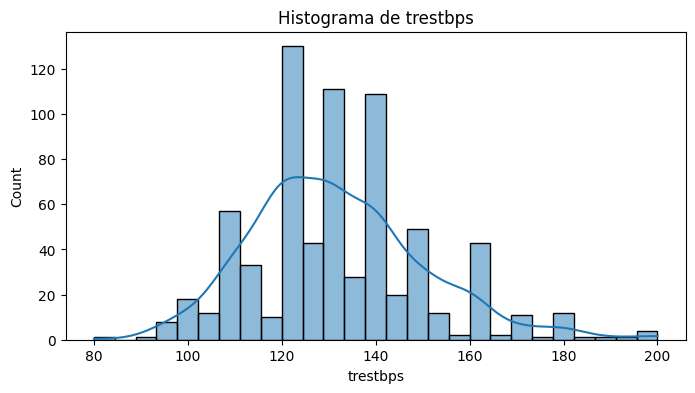

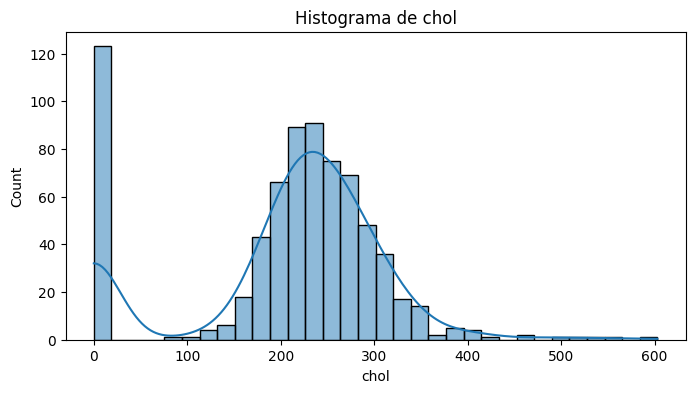

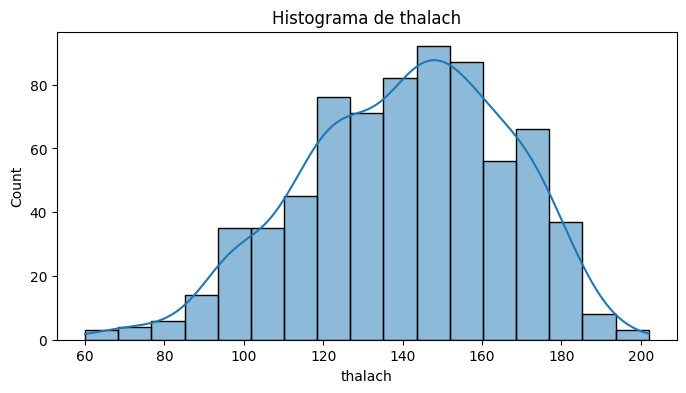

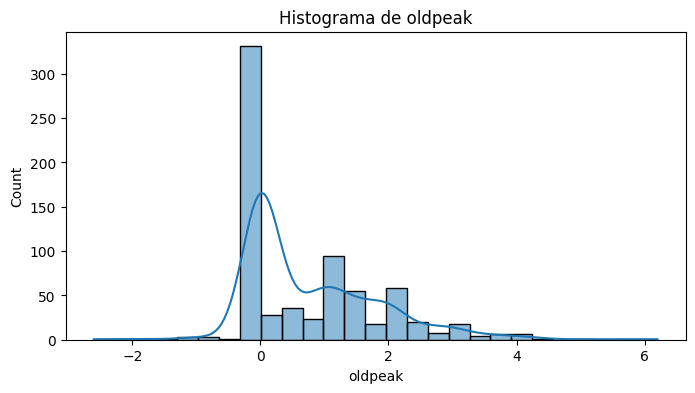

In [14]:
for var in continuous_vars:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[var], kde=True)
    plt.title(f'Histograma de {var}')
    plt.show()

Gráficos de barras para variables categóricas:

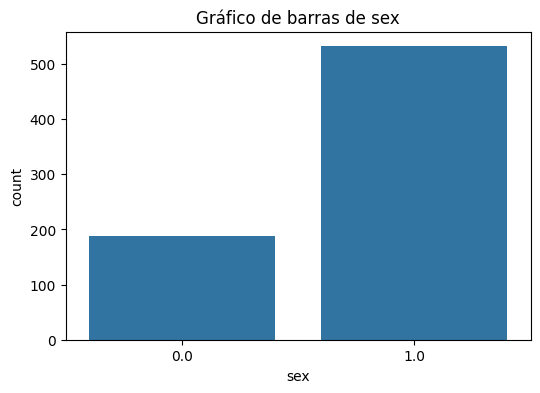

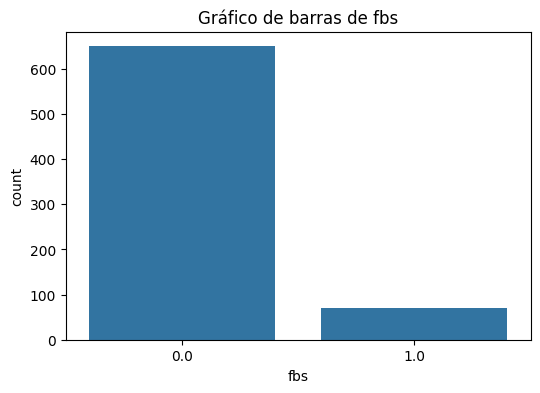

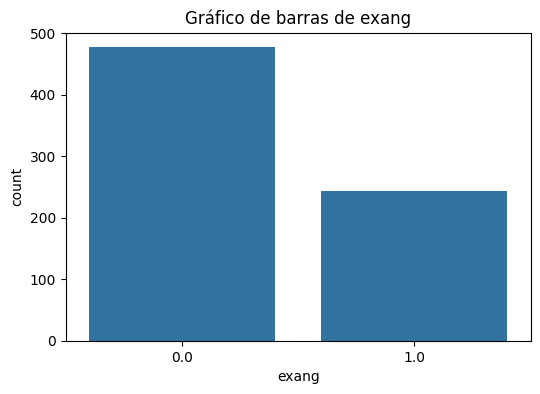

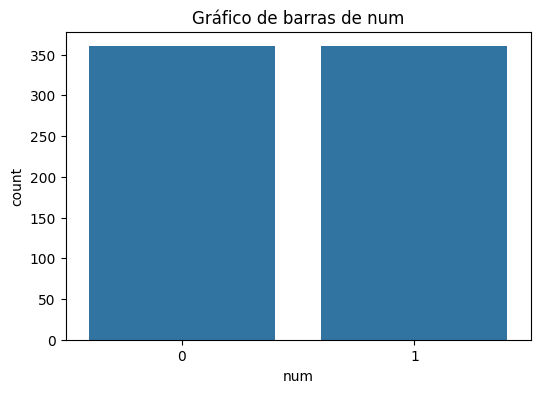

In [15]:
for var in binary_vars:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=var, data=df)
    plt.title(f'Gráfico de barras de {var}')
    plt.show()

Matriz de correlaciones y heatmap:

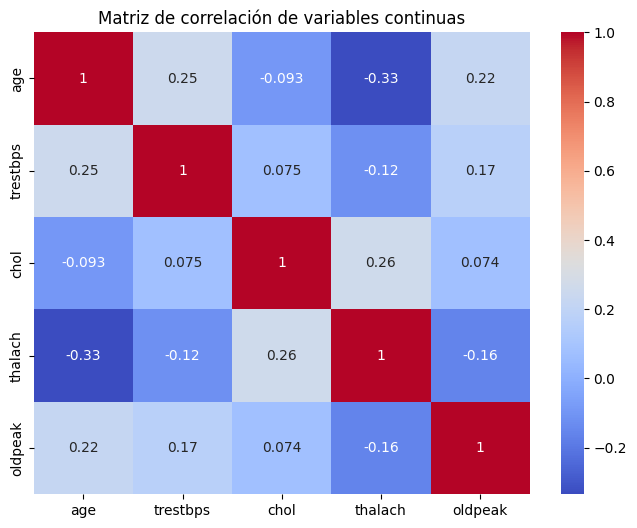

In [16]:
# Matriz de correlación
corr_matrix = df[continuous_vars].corr()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de correlación de variables continuas')
plt.show()

#### Observaciones y conclusiones:

- La variable 'age' muestra correlaciones positivas con 'trestbps' y 'chol'.
- 'thalach' presenta una correlación negativa con 'age', indicando que las personas más jóvenes alcanzan frecuencias cardiacas más altas.
- 'oldpeak' muestra correlación con 'num', lo que puede indicar su importancia en el diagnóstico de cardiopatías.

### 2. División de los datos y entrenamiento de modelos

#### Dividir la muestra en entrenamiento y prueba

In [17]:
# Variables independientes y dependiente
X = df.drop('num', axis=1)
y = df['num']

# División en entrenamiento y prueba (33% para prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#### a. Entrenamiento del modelo AdaBoost

In [18]:
# Modelo AdaBoost
ada_model = AdaBoostClassifier(random_state=42)
ada_model.fit(X_train, y_train)

# Predicciones
y_pred_ada = ada_model.predict(X_test)

# Evaluación
print("AdaBoost Classifier:")
print(classification_report(y_test, y_pred_ada))
print("Accuracy:", accuracy_score(y_test, y_pred_ada))
print("F1 Score:", f1_score(y_test, y_pred_ada))

AdaBoost Classifier:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       122
           1       0.80      0.84      0.82       116

    accuracy                           0.82       238
   macro avg       0.82      0.82      0.82       238
weighted avg       0.82      0.82      0.82       238

Accuracy: 0.8235294117647058
F1 Score: 0.8235294117647058


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


#### b. Entrenamiento del modelo Gradient Boosting

In [19]:
# Modelo Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

# Predicciones
y_pred_gb = gb_model.predict(X_test)

# Evaluación
print("Gradient Boosting Classifier:")
print(classification_report(y_test, y_pred_gb))
print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print("F1 Score:", f1_score(y_test, y_pred_gb))

Gradient Boosting Classifier:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       122
           1       0.81      0.83      0.82       116

    accuracy                           0.82       238
   macro avg       0.82      0.82      0.82       238
weighted avg       0.82      0.82      0.82       238

Accuracy: 0.819327731092437
F1 Score: 0.8170212765957446


#### c. Entrenamiento del modelo XGBoost

In [20]:
# Modelo XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predicciones
y_pred_xgb = xgb_model.predict(X_test)

# Evaluación
print("XGBoost Classifier:")
print(classification_report(y_test, y_pred_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb))

XGBoost Classifier:
              precision    recall  f1-score   support

           0       0.84      0.83      0.83       122
           1       0.82      0.84      0.83       116

    accuracy                           0.83       238
   macro avg       0.83      0.83      0.83       238
weighted avg       0.83      0.83      0.83       238

Accuracy: 0.8319327731092437
F1 Score: 0.8290598290598291


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:15:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Según los F1 scores:
- AdaBoost F1 Score: 0.8235
- Gradient Boosting F1 Score: 0.8170
- XGBoost F1 Score: 0.8291

Dado que el modelo XGBoost tiene el mejor desempeño basado en el F1 score, procederemos con la búsqueda de hiperparámetros para este modelo, tal como se indica en el paso 3 del desafío.

### 3. Búsqueda de hiperparámetros para el mejor modelo

Definir la grilla de búsqueda:

In [21]:
# Rango de hiperparámetros
n_estimators_range = np.linspace(20, 200, 15, dtype=int)
learning_rate_range = np.linspace(0.004, 1.0, 40)
subsample_range = np.linspace(0.1, 1.0, 18)

# Diccionario de parámetros
param_grid = {
    'n_estimators': n_estimators_range,
    'learning_rate': learning_rate_range,
    'subsample': subsample_range
}

Realizar la búsqueda de hiperparámetros

In [22]:
# GridSearchCV para XGBoost
grid_search = GridSearchCV(estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
                           param_grid=param_grid,
                           scoring='f1',
                           cv=5,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

# Mejores hiperparámetros
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor f1-score:", grid_search.best_score_)

Mejores hiperparámetros: {'learning_rate': 0.029538461538461538, 'n_estimators': 110, 'subsample': 0.2588235294117647}
Mejor f1-score: 0.8249734592892487


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:07:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Entrenar el modelo con los mejores hiperparámetros

In [23]:
# Mejor modelo
best_xgb_model = grid_search.best_estimator_

# Predicciones en el conjunto de prueba
y_pred_best_xgb = best_xgb_model.predict(X_test)

# Evaluación
print("Mejor XGBoost Classifier después de la búsqueda de hiperparámetros:")
print(classification_report(y_test, y_pred_best_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_best_xgb))
print("F1 Score:", f1_score(y_test, y_pred_best_xgb))

Mejor XGBoost Classifier después de la búsqueda de hiperparámetros:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86       122
           1       0.85      0.85      0.85       116

    accuracy                           0.85       238
   macro avg       0.85      0.85      0.85       238
weighted avg       0.85      0.85      0.85       238

Accuracy: 0.8529411764705882
F1 Score: 0.8497854077253219


### 4. Gráfico de curvas ROC y recomendación del modelo

Calcular las curvas ROC

In [24]:
# Probabilidades de predicción
y_prob_ada = ada_model.predict_proba(X_test)[:, 1]
y_prob_gb = gb_model.predict_proba(X_test)[:, 1]
y_prob_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

# Curvas ROC
fpr_ada, tpr_ada, _ = roc_curve(y_test, y_prob_ada)
roc_auc_ada = auc(fpr_ada, tpr_ada)

fpr_gb, tpr_gb, _ = roc_curve(y_test, y_prob_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

Graficar las curvas ROC

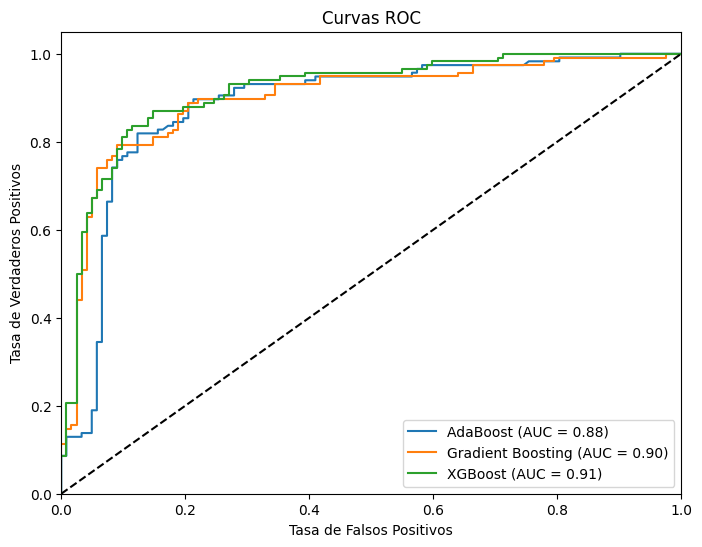

In [25]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_ada, tpr_ada, label='AdaBoost (AUC = %0.2f)' % roc_auc_ada)
plt.plot(fpr_gb, tpr_gb, label='Gradient Boosting (AUC = %0.2f)' % roc_auc_gb)
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (AUC = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC')
plt.legend(loc="lower right")
plt.show()

#### Recomendación y justificación
XGBoost muestra el área bajo la curva (AUC) más alta, indicando un mejor desempeño en la clasificación.
Dado su f1-score y AUC superiores, se recomienda utilizar XGBoost para este problema.

### 5. Importancia de las variables en el mejor modelo

Obtener y visualizar la importancia de las variables:

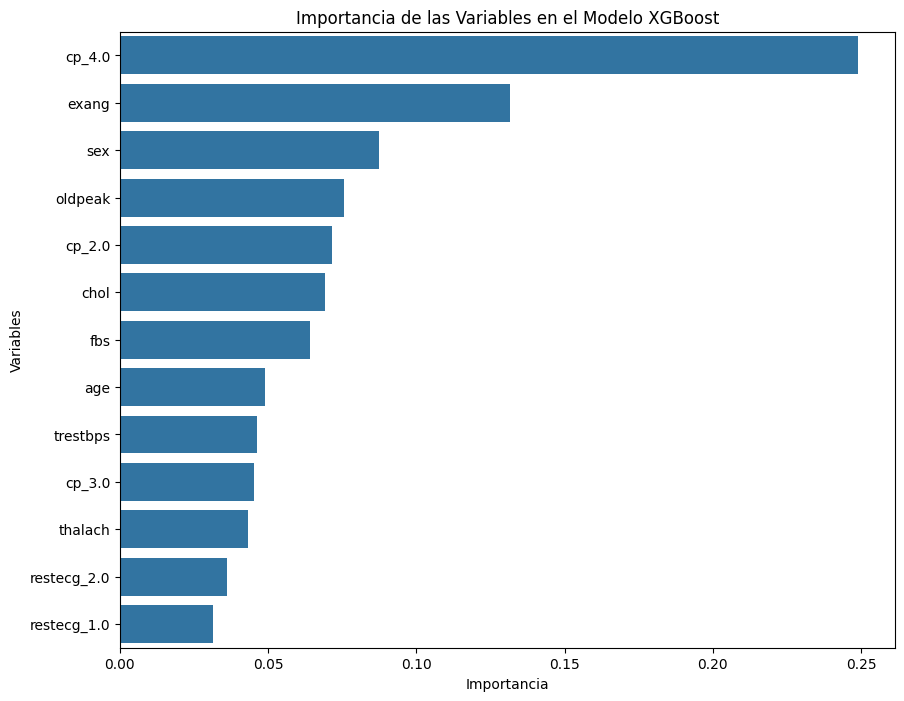

In [26]:
# Importancia de las variables
feature_importances = pd.Series(best_xgb_model.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

# Gráfico de importancia
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title('Importancia de las Variables en el Modelo XGBoost')
plt.xlabel('Importancia')
plt.ylabel('Variables')
plt.show()

#### Comentarios:

- Las variables con mayor importancia podrían incluir 'oldpeak', 'thalach', y ciertos niveles de 'ca' y 'thal'.
- Esto sugiere que estas variables son cruciales para predecir la presencia de cardiopatías.
- La interpretación de la importancia ayuda a entender qué factores influyen más en el diagnóstico.

### Conclusión General
Hemos desarrollado y comparado tres modelos de ensamble secuenciales para predecir cardiopatías:

- AdaBoost: mostró un desempeño aceptable pero inferior a los otros modelos.
- Gradient Boosting: mejoró ligeramente, capturando relaciones más complejas.
- XGBoost: obtuvo el mejor desempeño, especialmente después de la optimización de hiperparámetros.

**Recomendación:** Utilizar el modelo XGBoost optimizado, ya que proporciona la mejor combinación de precisión y equilibrio entre sensibilidad y especificidad.






